In [7]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'numpy'

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, accuracy_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")

In [ ]:
random.seed(42)
np.random.seed(42)

n_machines = 10
machine_ids = [f"CM_{i:03d}" for i in range(1, n_machines+1)]
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 10, 1)  
days = (end_date - start_date).days + 1

rows = []
for m in machine_ids:
    
    baseline_serves = random.randint(30, 200)
    baseline_vib = random.uniform(0.2, 1.5)
    baseline_error_rate = random.uniform(0.01, 0.15) 
    
    for d in range(days):
        date = start_date + timedelta(days=d)
        day_of_year = date.timetuple().tm_yday

        
        seasonal_temp = 15 + 10 * np.sin(2 * np.pi * (day_of_year/365.0)) 
        avg_temp = seasonal_temp + np.random.normal(0, 2)  # +/-2C noise

       
        temp_mult = 1.0 + 0.02 * (20 - avg_temp)  
        cup_serves = np.random.poisson(max(1, baseline_serves * temp_mult))

        
        water_pH = np.clip(np.random.normal(7.0, 0.3), 5.5, 8.5)

       
        cleaning_done = 'Yes' if (d % 7 == (random.randint(0,6))) else ('No' if random.random() < 0.05 else 'Yes')

       
        vib = abs(np.random.normal(baseline_vib, 0.2))
        if random.random() < 0.005:  # rare spike
            vib += np.random.uniform(0.5, 2.0)

       
        err = np.random.poisson(baseline_error_rate * cup_serves)
        if random.random() < 0.01:
            err += random.randint(1,4)

        
        days_since_service = random.randint(0, 120)
        last_service_date = date - timedelta(days=days_since_service)

        rows.append({
            'machine_id': m,
            'date': date,
            'cup_serves': int(cup_serves),
            'avg_temp': round(float(avg_temp), 2),
            'water_pH': round(float(water_pH), 2),
            'cleaning_done': cleaning_done,
            'vibration_level': round(float(vib), 3),
            'error_count': int(err),
            'last_service_date': last_service_date.date(),
            'days_since_service': days_since_service
        })

df = pd.DataFrame(rows)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle rows
print("Rows:", df.shape[0])
df.head()

Rows: 6400


,machine_id,date,cup_serves,avg_temp,water_pH,cleaning_done,vibration_level,error_count,last_service_date,days_since_service
0,CM_004,2024-03-13,47,26.49,7.18,Yes,0.687,7,2024-02-03,39
1,CM_005,2024-08-03,130,8.21,7.03,Yes,0.515,6,2024-07-29,5
2,CM_007,2024-11-18,100,7.65,7.10,Yes,0.509,6,2024-10-16,33
3,CM_009,2025-01-17,74,17.88,6.90,Yes,1.146,9,2024-11-12,66
4,CM_001,2024-05-12,178,22.19,7.04,Yes,0.418,25,2024-02-07,95


In [ ]:
def failure_probability(row):
   
    w_cups = 0.003
    w_temp = 0.01 * abs(row['avg_temp'] - 20) / 10.0 
    w_ph = 1.0 * abs(row['water_pH'] - 7.0)
    w_vib = 1.0 * row['vibration_level']
    w_err = 0.4 * row['error_count']
    w_service = 0.015 * row['days_since_service']
    w_clean = 0.8 if row['cleaning_done'] == 'No' else 0.0

    linear = -3.5 + w_cups * row['cup_serves'] + w_temp + w_ph + w_vib + w_err + w_service + w_clean
    prob = 1 / (1 + np.exp(-linear))
    return prob

df['failure_prob'] = df.apply(failure_probability, axis=1)
df['failure_within_7d'] = df['failure_prob'].apply(lambda p: np.random.binomial(1, p))

df['failure_within_7d'].mean()  

np.float64(0.828125)

In [ ]:
print(df[['machine_id','date','cup_serves','avg_temp','water_pH','cleaning_done','vibration_level','error_count','days_since_service','failure_within_7d']].head(10))
df.to_csv('coffee_machine_data.csv', index=False)
print("Saved coffee_machine_data.csv")

  machine_id       date  cup_serves  avg_temp  water_pH cleaning_done  \
0     CM_004 2024-03-13          47     26.49      7.18           Yes   
1     CM_005 2024-08-03         130      8.21      7.03           Yes   
2     CM_007 2024-11-18         100      7.65      7.10           Yes   
3     CM_009 2025-01-17          74     17.88      6.90           Yes   
4     CM_001 2024-05-12         178     22.19      7.04           Yes   
5     CM_005 2025-03-07          96     23.01      6.87           Yes   
6     CM_008 2025-03-09          40     24.05      7.58           Yes   
7     CM_004 2024-06-24          62     14.04      6.75           Yes   
8     CM_004 2024-09-01          72      8.52      7.31           Yes   
9     CM_008 2024-04-16          38     21.88      6.71           Yes   

   vibration_level  error_count  days_since_service  failure_within_7d  
0            0.687            7                  39                  1  
1            0.515            6                   

Failure rate: 0.828125


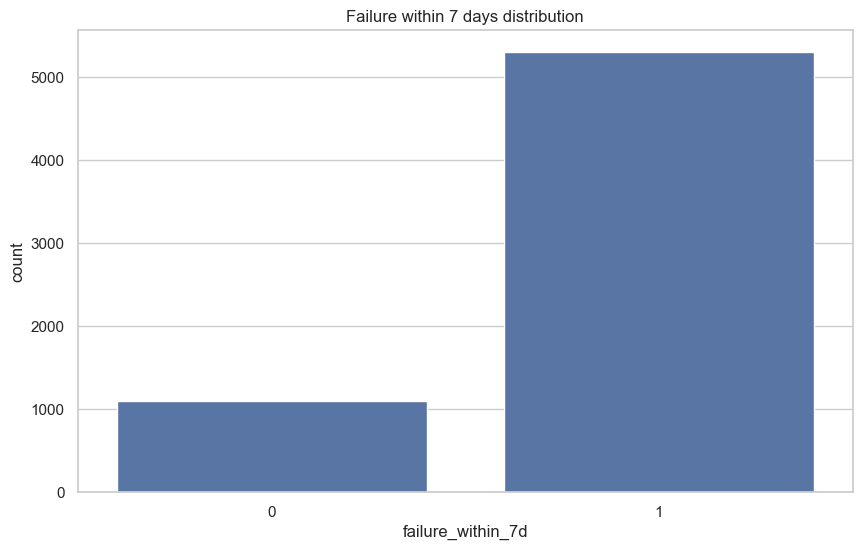

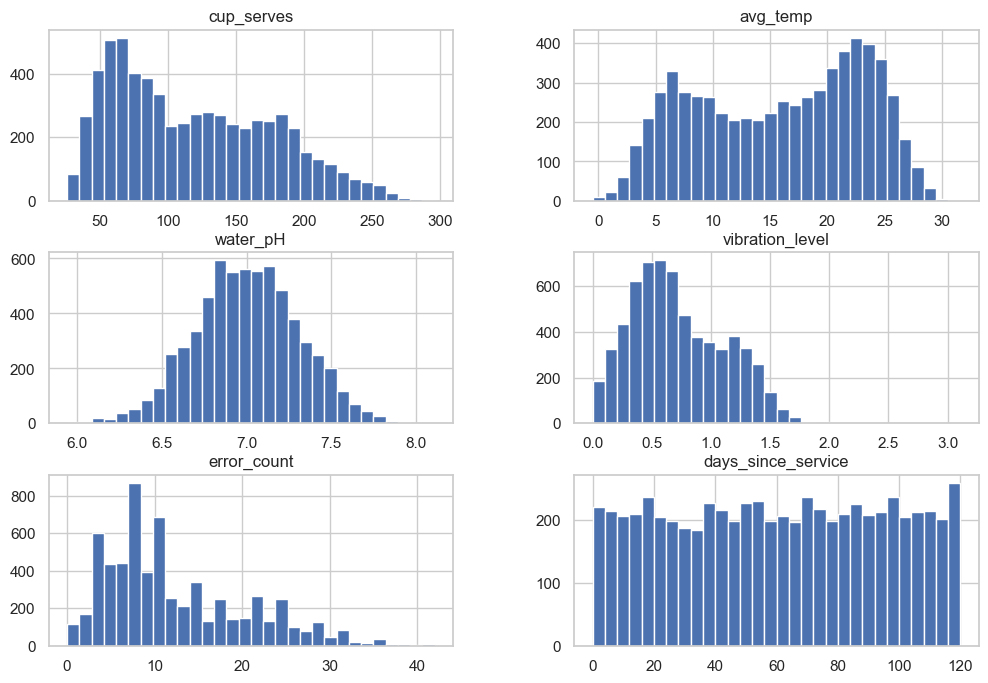

Correlation matrix:
                     cup_serves  avg_temp  water_pH  vibration_level  \
cup_serves            1.000000 -0.269917 -0.001893         0.219566   
avg_temp             -0.269917  1.000000  0.025171        -0.010104   
water_pH             -0.001893  0.025171  1.000000         0.009221   
vibration_level       0.219566 -0.010104  0.009221         1.000000   
error_count           0.793801 -0.196518 -0.012285         0.080853   
days_since_service    0.008862  0.005234 -0.020733         0.018891   
failure_within_7d     0.383346 -0.070151  0.010774         0.207500   

                    error_count  days_since_service  failure_within_7d  
cup_serves             0.793801            0.008862           0.383346  
avg_temp              -0.196518            0.005234          -0.070151  
water_pH              -0.012285           -0.020733           0.010774  
vibration_level        0.080853            0.018891           0.207500  
error_count            1.000000            0.

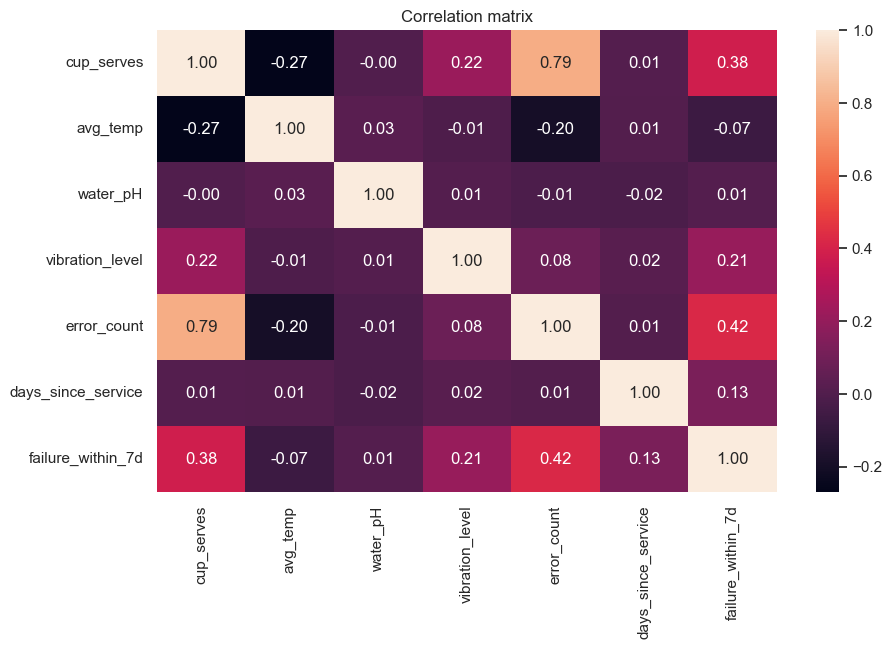

In [ ]:
print("Failure rate:", df['failure_within_7d'].mean())
sns.countplot(x='failure_within_7d', data=df)
plt.title("Failure within 7 days distribution")
plt.show()

df[['cup_serves','avg_temp','water_pH','vibration_level','error_count','days_since_service']].hist(bins=30, figsize=(12,8))
plt.show()

numeric_cols = ['cup_serves','avg_temp','water_pH','vibration_level','error_count','days_since_service','failure_within_7d']
corr = df[numeric_cols].corr()
print("Correlation matrix:\n", corr)
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation matrix")
plt.show()

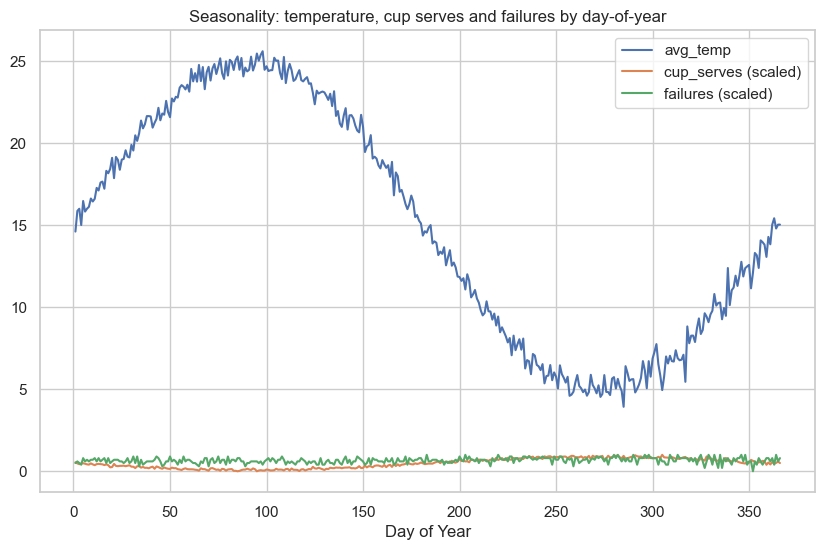

In [ ]:
df['doy'] = df['date'].dt.dayofyear
daily = df.groupby('doy').agg({
    'avg_temp':'mean',
    'cup_serves':'mean',
    'failure_within_7d':'mean'
}).reset_index()

plt.plot(daily['doy'], daily['avg_temp'], label='avg_temp')
plt.plot(daily['doy'], (daily['cup_serves']-daily['cup_serves'].min())/(daily['cup_serves'].max()-daily['cup_serves'].min()), label='cup_serves (scaled)')
plt.plot(daily['doy'], (daily['failure_within_7d']-daily['failure_within_7d'].min())/(daily['failure_within_7d'].max()-daily['failure_within_7d'].min()), label='failures (scaled)')
plt.legend()
plt.title("Seasonality: temperature, cup serves and failures by day-of-year")
plt.xlabel("Day of Year")
plt.show()

In [ ]:
df_sorted = df.sort_values(['machine_id','date']).copy()
df_sorted['cleaning_flag'] = df_sorted['cleaning_done'].map({'Yes':0,'No':1})

df_sorted['cup_7d_avg'] = df_sorted.groupby('machine_id')['cup_serves'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df_sorted['err_7d_sum'] = df_sorted.groupby('machine_id')['error_count'].transform(lambda x: x.rolling(7, min_periods=1).sum())
df_sorted['vib_7d_avg'] = df_sorted.groupby('machine_id')['vibration_level'].transform(lambda x: x.rolling(7, min_periods=1).mean())

le = LabelEncoder()
df_sorted['machine_label'] = le.fit_transform(df_sorted['machine_id'])

features = ['machine_label','cup_serves','cup_7d_avg','avg_temp','water_pH','cleaning_flag',
            'vibration_level','vib_7d_avg','error_count','err_7d_sum','days_since_service']
X = df_sorted[features]
y = df_sorted['failure_within_7d']

X.head()

,machine_label,cup_serves,cup_7d_avg,avg_temp,water_pH,cleaning_flag,vibration_level,vib_7d_avg,error_count,err_7d_sum,days_since_service
3192,0,218,218.00,16.17,6.96,0,0.298,0.298000,26,26.0,114
4654,0,229,223.50,14.88,6.86,0,0.252,0.275000,23,49.0,27
4867,0,228,225.00,12.07,6.83,0,0.163,0.237667,25,74.0,83
5414,0,206,220.25,12.86,6.84,0,0.367,0.270000,25,99.0,103
5950,0,222,220.60,14.66,6.91,1,0.342,0.284400,21,120.0,43


PCA explained variance ratios: [0.351 0.164 0.095 0.093 0.09 ]


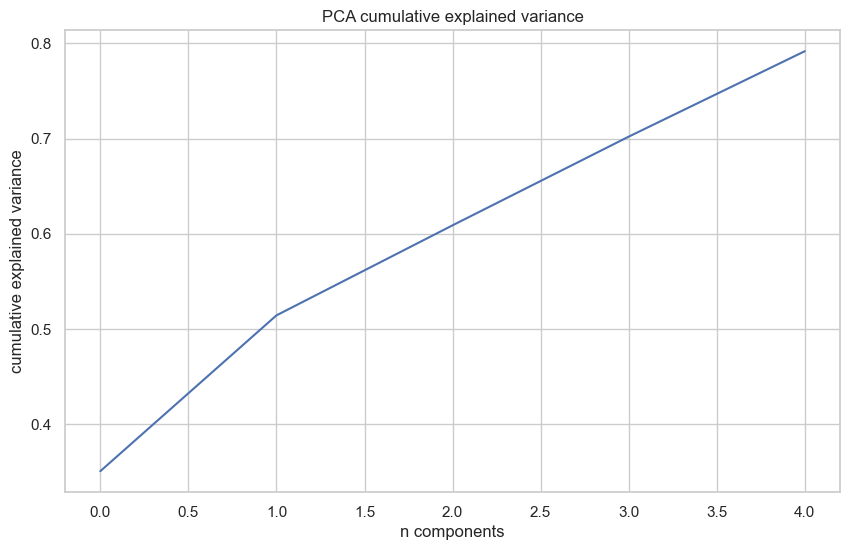

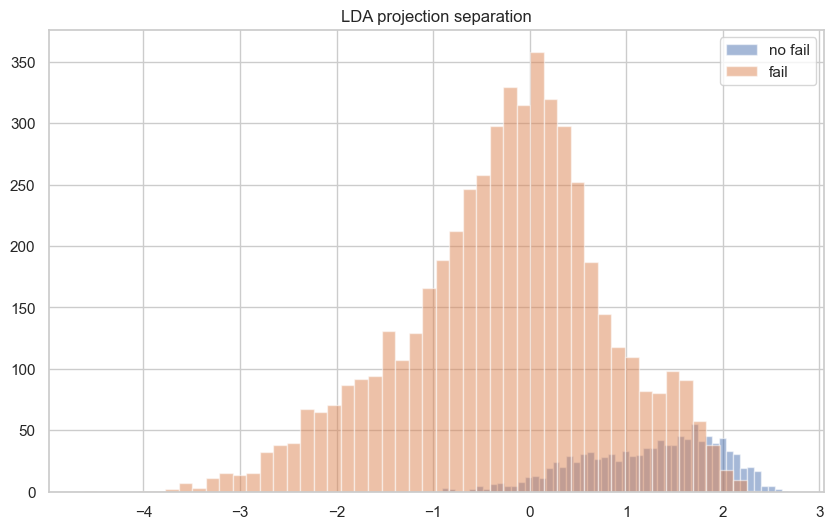

In [ ]:
from sklearn.pipeline import Pipeline

numeric_feats = features.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
pca_res = pca.fit_transform(X_scaled)
print("PCA explained variance ratios:", pca.explained_variance_ratio_.round(3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative explained variance")
plt.title("PCA cumulative explained variance")
plt.show()

lda = LinearDiscriminantAnalysis(n_components=1)
lda_res = lda.fit_transform(X_scaled, y)
plt.hist(lda_res[y==0], bins=50, alpha=0.5, label='no fail')
plt.hist(lda_res[y==1], bins=50, alpha=0.5, label='fail')
plt.legend()
plt.title("LDA projection separation")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'SVM': SVC(probability=True, gamma='scale', random_state=42)
}
if has_xgb:
    models['XGBoost'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"\nModel: {name}")
    print("CV ROC-AUC (train):", scores.mean().round(3), " std:", scores.std().round(3))
    print("Test AUC:", round(auc,3))
    print(classification_report(y_test, y_pred, digits=3))
    results[name] = {'model': model, 'auc': auc, 'y_pred': y_pred, 'y_proba': y_proba}


Model: LogisticRegression
CV ROC-AUC (train): 0.901  std: 0.004
Test AUC: 0.911
              precision    recall  f1-score   support

           0      0.670     0.591     0.628       220
           1      0.917     0.940     0.928      1060

    accuracy                          0.880      1280
   macro avg      0.794     0.765     0.778      1280
weighted avg      0.875     0.880     0.877      1280


Model: RandomForest
CV ROC-AUC (train): 0.882  std: 0.008
Test AUC: 0.902
              precision    recall  f1-score   support

           0      0.613     0.518     0.562       220
           1      0.903     0.932     0.917      1060

    accuracy                          0.861      1280
   macro avg      0.758     0.725     0.739      1280
weighted avg      0.853     0.861     0.856      1280


Model: SVM
CV ROC-AUC (train): 0.842  std: 0.011
Test AUC: 0.879
              precision    recall  f1-score   support

           0      0.671     0.455     0.542       220
           1   

Best model: LogisticRegression AUC: 0.911367924528302


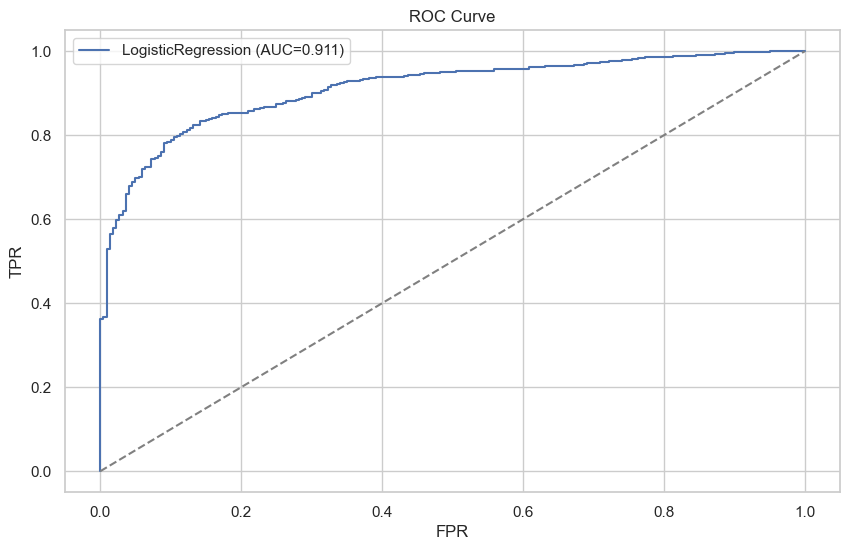

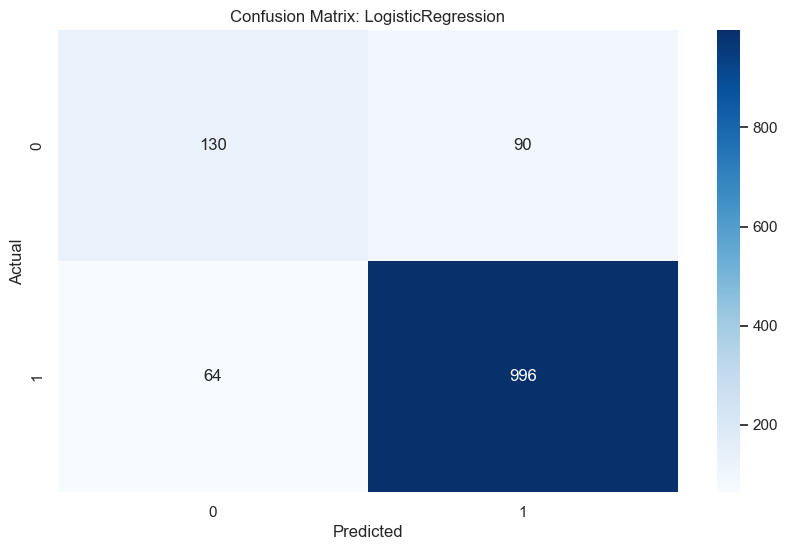

In [ ]:
best_name = max(results.items(), key=lambda kv: kv[1]['auc'])[0]
best = results[best_name]['model']
print("Best model:", best_name, "AUC:", results[best_name]['auc'])

fpr, tpr, _ = roc_curve(y_test, results[best_name]['y_proba'])
plt.plot(fpr, tpr, label=f'{best_name} (AUC={results[best_name]["auc"]:.3f})')
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

cm = confusion_matrix(y_test, results[best_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix: {best_name}')
plt.show()

machine_label         0.030608
err_7d_sum            0.038330
avg_temp              0.042767
water_pH              0.056154
vib_7d_avg            0.091671
cup_7d_avg            0.100220
cup_serves            0.149546
cleaning_flag         0.152199
vibration_level       0.298256
days_since_service    0.525100
error_count           3.210289
dtype: float64


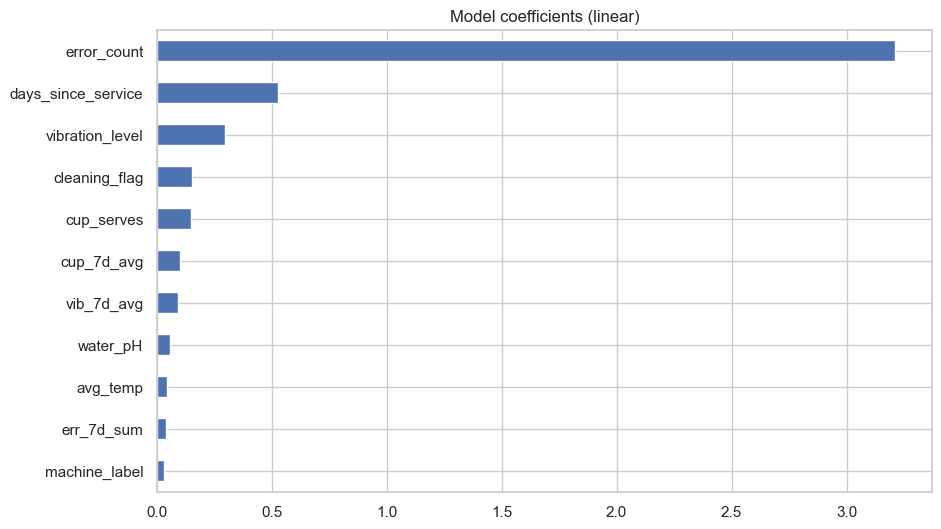

In [ ]:
if hasattr(best, 'feature_importances_'):
    importances = best.feature_importances_
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    print(fi)
    fi.plot(kind='bar')
    plt.title('Feature importances (tree-based model)')
    plt.show()
elif hasattr(best, 'coef_'):
    coefs = best.coef_[0]
    coef_s = pd.Series(coefs, index=features).sort_values()
    print(coef_s)
    coef_s.plot(kind='barh')
    plt.title('Model coefficients (linear)')
    plt.show()
else:
    print("Model does not expose feature importances/coefficients.")

In [ ]:
df_sorted.head(20).to_csv('coffee_machine_data_sample.csv', index=False)
print("Sample saved to coffee_machine_data_sample.csv")
summary = df_sorted.groupby('machine_id')['failure_within_7d'].mean().sort_values(ascending=False)
print("Failure rate by machine (sample):\n", summary.head())

Sample saved to coffee_machine_data_sample.csv
Failure rate by machine (sample):
 machine_id
CM_001    1.000000
CM_006    0.998437
CM_010    0.992188
CM_003    0.912500
CM_005    0.895312
Name: failure_within_7d, dtype: float64
